True

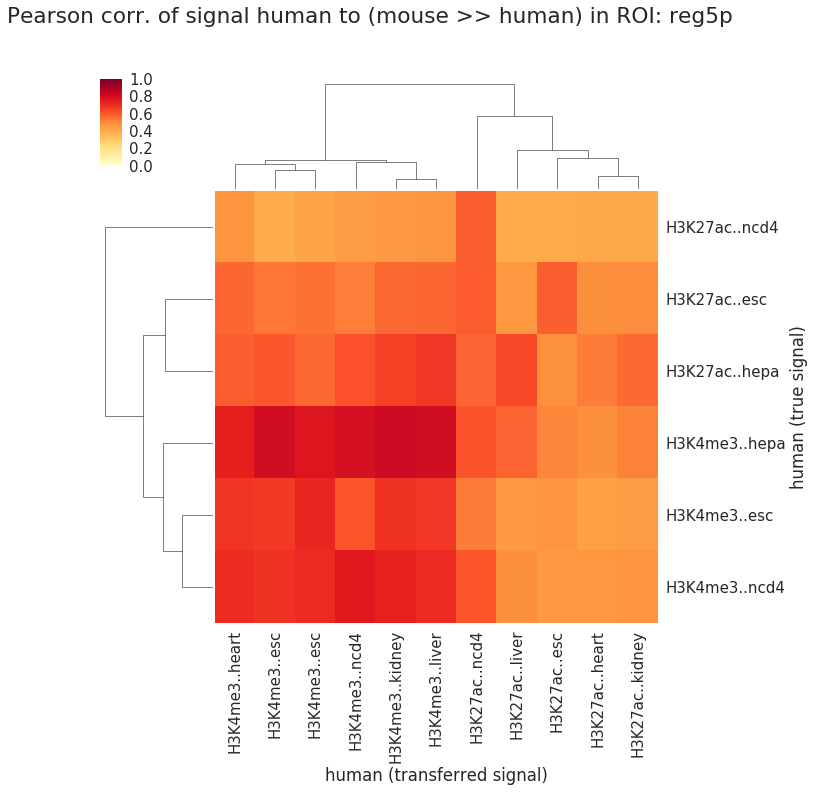

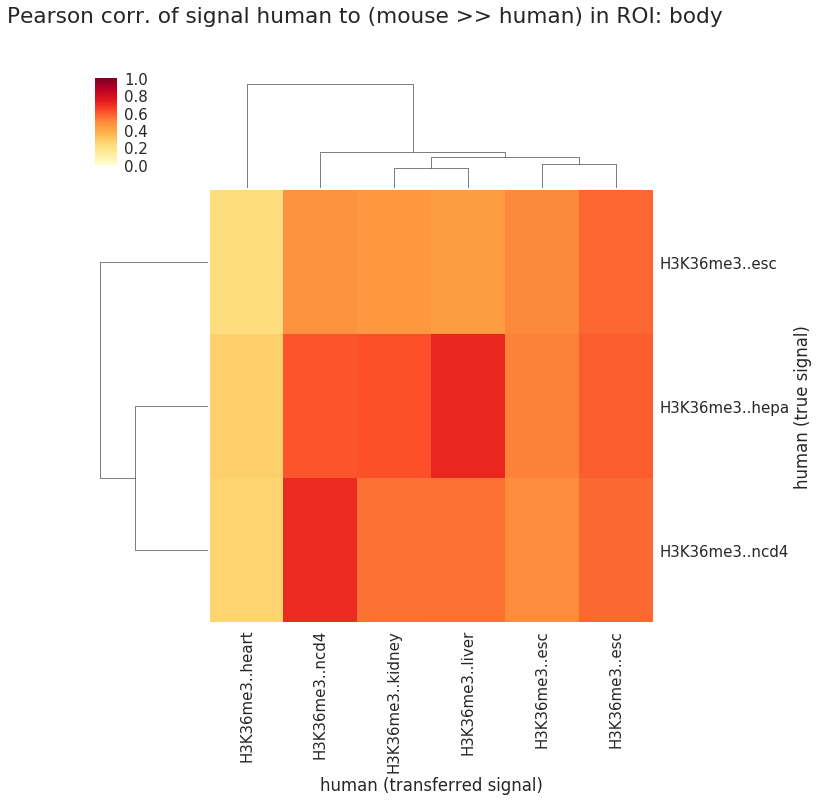

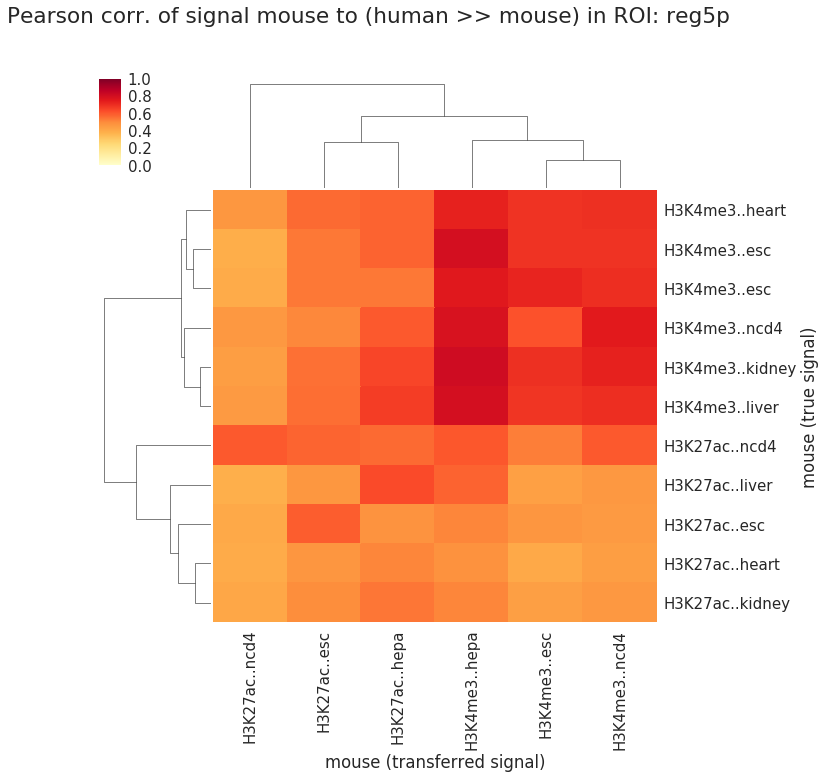

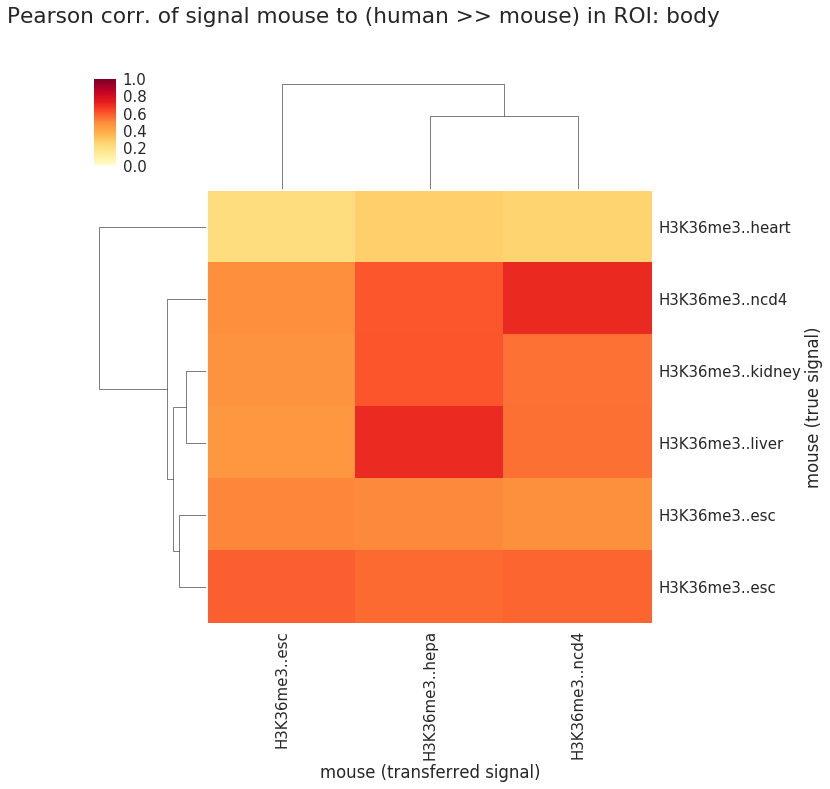

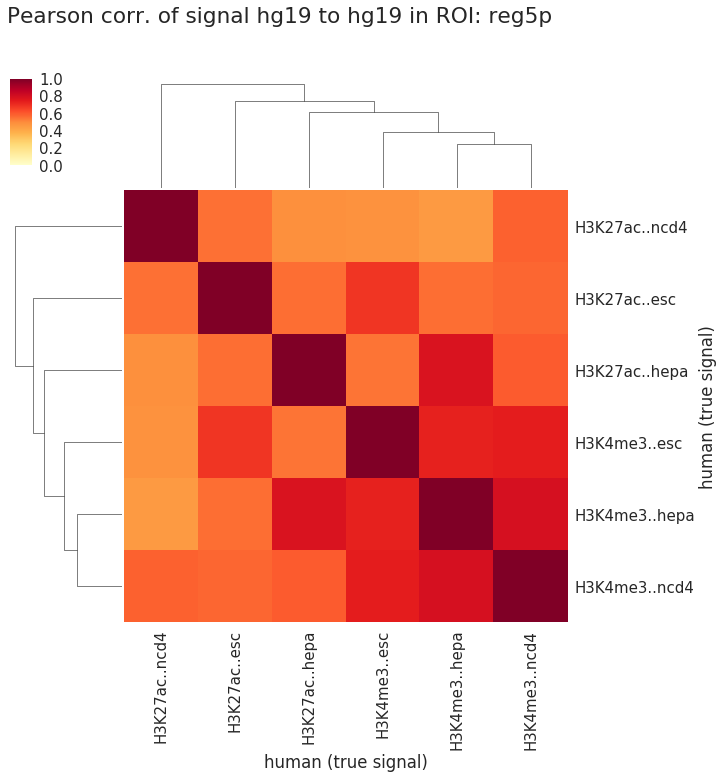

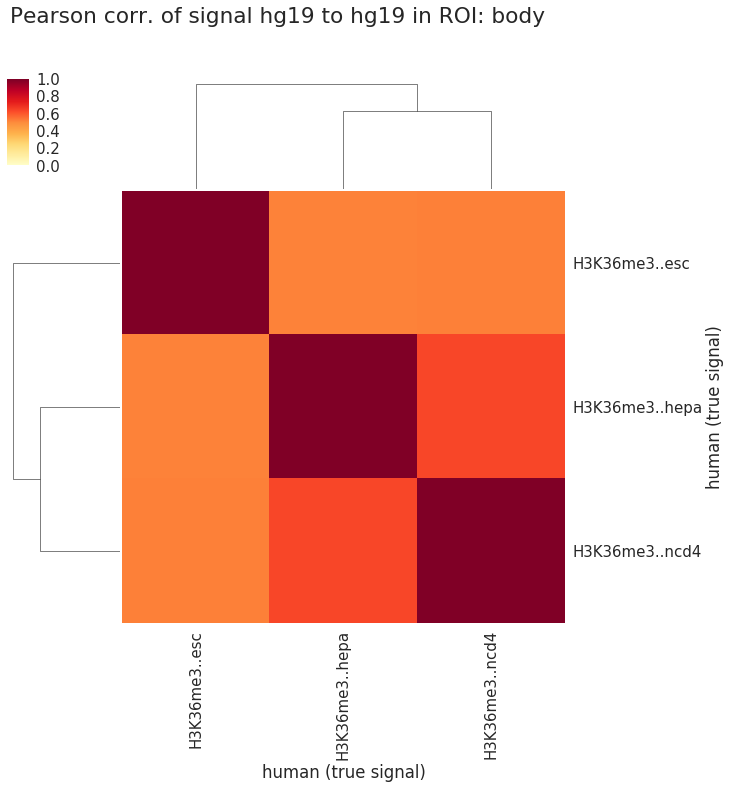

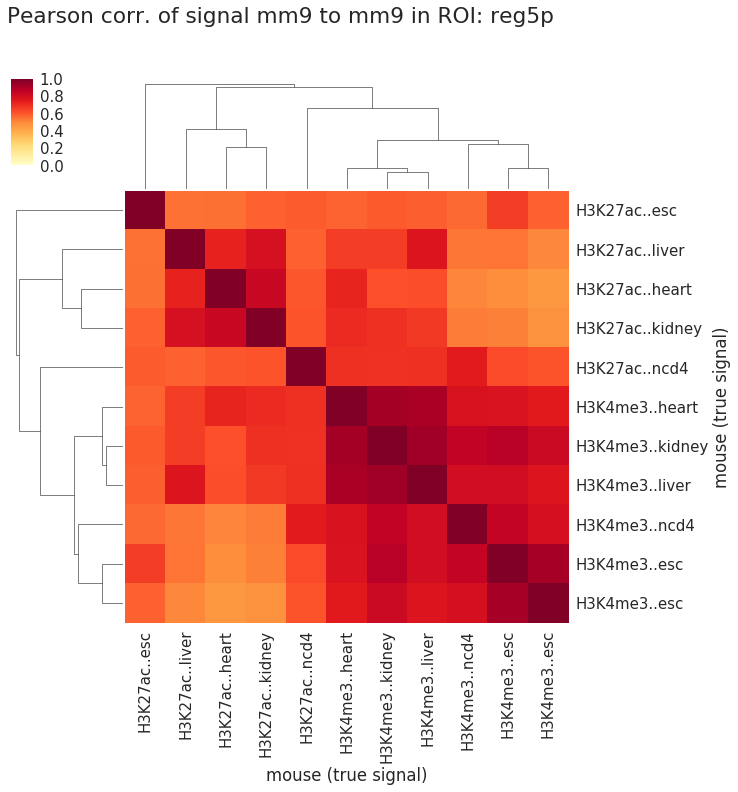

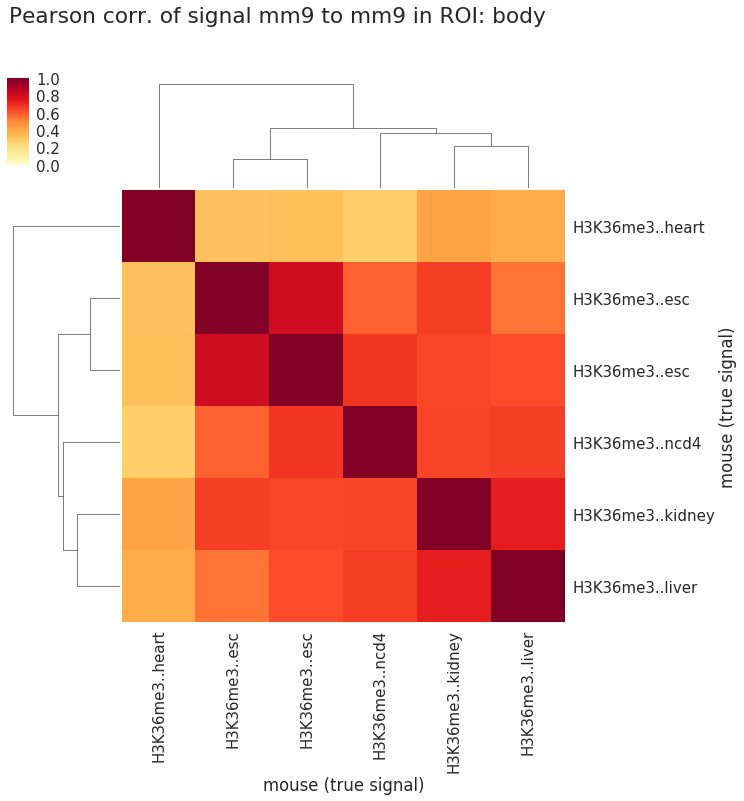

In [5]:
%matplotlib inline

import os as os
import matplotlib.pyplot as plt
import fnmatch as fnm
import json as js
import collections as col

import scipy.cluster.hierarchy as hc
import scipy.spatial.distance as dst
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

exec_src_corr = True
exec_map_corr = True

save_figures = True

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))

base_path = '/TL/deep/fhgfs/projects/pebert/thesis/projects/cross_species/processing/norm'
src_corr = os.path.join(base_path, 'task_signal_correlation/sub_roi')
map_corr = os.path.join(base_path, 'task_signal_mapping/mapcorr/corr_roi')

outfolder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub/supp'

prom_marks = ['H3K4me3', 'H3K27ac']
body_marks = ['H3K36me3']


def load_json(fpath):
    collector = []
    measure = 'pearson'
    with open(fpath, 'r') as dump:
        data = js.load(dump)['correlations']
        for chrom, info in data:
            collector.append(info[measure]['stat'])
    return np.median(collector)


def plot_heatmap(dataset, title):
    
    if dataset.shape == (15, 30):
        fig, ax = plt.subplots(figsize=(20, 15))
        cbar_ax = fig.add_axes([0.95, 0.3, 0.035, 0.4])
    elif dataset.shape == (15, 15):
        fig, ax = plt.subplots(figsize=(15, 15))
        cbar_ax = fig.add_axes([0.95, 0.3, 0.035, 0.4])
    elif dataset.shape == (30, 30):
        fig, ax = plt.subplots(figsize=(20, 20))
        cbar_ax = fig.add_axes([0.95, 0.3, 0.035, 0.4])
    elif dataset.shape in [(6, 11), (3, 11), (6, 6), (3, 6), (6, 3), (11, 11)]:
        fig, ax = plt.subplots(figsize=(10, 8))
        cbar_ax = fig.add_axes([0.95, 0.3, 0.035, 0.4])
    elif dataset.shape == (11, 6):
        fig, ax = plt.subplots(figsize=(10, 8))
        cbar_ax = fig.add_axes([0.75, 0.3, 0.035, 0.4])
    elif dataset.shape == (3, 3):
        fig, ax = plt.subplots(figsize=(6, 4))
        cbar_ax = fig.add_axes([0.8, 0.3, 0.035, 0.4])
    else:
        raise AssertionError()
    row_labels = ['..'.join(l.split('_')[:2]) for l in dataset.index.tolist()]
    col_labels = ['..'.join(l.split('_')[:2]) for l in dataset.columns]
    if dataset.shape[0] == len(row_labels):
        x_labels = col_labels
        y_labels = row_labels
    else:
        x_labels = row_labels
        y_labels = col_labels
    hm = sns.heatmap(dataset, vmin=0, vmax=1, cmap="YlOrRd", center=0.5, annot=False,
                     xticklabels=x_labels, yticklabels=y_labels, square=True, linewidths=0.5,
                     ax=ax, cbar_ax=cbar_ax)
    ax.set_title(title, fontsize=16)
    return fig


def plot_clustermap(dataset, title, xlab, ylab):
    """
    """
    new_cols = []
    for c in dataset.columns:
        mark, tissue, _ = c.split('_')
        if tissue in ['H1hESC', 'ESE14']:
            tissue = 'esc'
        new_cols.append('..'.join([mark, tissue]))
    dataset.columns = new_cols
    
    new_idx = []
    for i in dataset.index:
        mark, tissue, _ = i.split('_')
        if tissue in ['H1hESC', 'ESE14']:
            tissue = 'esc'
        new_idx.append('..'.join([mark, tissue]))
    dataset.index = new_idx
    if dataset.shape[0] == dataset.shape[1]:
        dist_data = dst.squareform(1 - dataset.values)
        link = hc.linkage(dist_data, method='average', metric='euclidean')
        cm = sns.clustermap(dataset, vmin=0, vmax=1, cmap="YlOrRd", center=0.5, annot=False,
                            row_cluster=True, col_cluster=True, row_linkage=link, col_linkage=link,
                            square=False)
        hm_ax = cm.ax_heatmap
        if dataset.shape == (3, 3):
            yticks = hm_ax.get_ymajorticklabels()
            for item in yticks:
                item.set_rotation(0)
        
            xticks = hm_ax.get_xmajorticklabels()
            for item in xticks:
                item.set_rotation(90)
    else:
        cm = sns.clustermap(dataset, vmin=0, vmax=1, cmap="YlOrRd", center=0.5, annot=False,
                            row_cluster=True, col_cluster=True, method='average', metric='euclidean',
                            square=False)
        hm_ax = cm.ax_heatmap
        if dataset.shape == (3, 6):
            yticks = hm_ax.get_ymajorticklabels()
            for item in yticks:
                item.set_rotation(0)
        elif dataset.shape == (6, 3):
            xticks = hm_ax.get_xmajorticklabels()
            for item in xticks:
                item.set_rotation(90)
        else:
            pass
    hm_ax.set_xlabel(xlab)
    hm_ax.set_ylabel(ylab)
    fig = cm.fig
    exart = [fig.suptitle(title)]
    
    return cm, exart


def run_map_corr():
    if not exec_map_corr:
        return False
    corr_files = os.listdir(map_corr)
    for assm in ['hg19', 'mm9']:
        for region in ['reg5p', 'body']:
            datafiles = fnm.filter(corr_files, '*_{}_*_vs_*{}.json'.format(assm, region))
            rows = col.defaultdict(list)
            for df in datafiles:
                comp = df.split('.')[0].split('_')
                l1 = '_'.join([comp[4], comp[3], comp[1]])
                l2 = '_'.join([comp[9], comp[8], comp[6]])
                if region == 'reg5p':
                    if not (comp[4] in prom_marks and comp[9] in prom_marks):
                        continue
                if region == 'body':
                    if not (comp[4] in body_marks and comp[9] in body_marks):
                        continue
                stat = load_json(os.path.join(map_corr, df))
                rows[l1].append((l2, stat))
            prep = []
            for label, row in rows.items():
                df = pd.DataFrame([[x[1] for x in row]], dtype=np.float32,
                                   columns=[x[0] for x in row], index=[label])
                prep.append(df)
            df = pd.concat(prep, axis=0, ignore_index=False)
            df.sort_index(axis=0, inplace=True)
            other = 'mm9' if assm == 'hg19' else 'hg19'
            spec_a = plot_colors['mapping'][assm]['species']
            spec_b = plot_colors['mapping'][other]['species']
            title = 'Pearson corr. of signal {} to ({} >> {}) in ROI: {}'.format(spec_a, spec_b, spec_a, region)
            #hm = plot_heatmap(df, title)
            xlabel = '{} (transferred signal)'.format(spec_a)
            ylabel = '{} (true signal)'.format(spec_a)
            cm, exart = plot_clustermap(df, title, xlabel, ylabel)
            
            if save_figures:
                outname = '_'.join(['fig_X_supp_corr', assm, other, region])
                outpath = os.path.join(outfolder, outname + '.svg')
                cm.savefig(outpath, bbox_inches='tight', extra_artists=exart)
                outpath = os.path.join(outfolder, outname + '.png')
                cm.savefig(outpath, bbox_inches='tight', extra_artists=exart, dpi=300)
    return True


def run_src_corr():
    if not exec_src_corr:
        return False
    corr_files = os.listdir(src_corr)
    for assm in ['hg19', 'mm9']:
        for region in ['reg5p', 'body']:
            datafiles = fnm.filter(corr_files, '*_{}_*_{}.json'.format(assm, region))
            rows = col.defaultdict(list)
            for df in datafiles:
                comp = df.split('.')[0].split('_')
                l1 = '_'.join([comp[4], comp[3], comp[1]])
                l2 = '_'.join([comp[9], comp[8], comp[6]])
                if region == 'reg5p':
                    if not (comp[4] in prom_marks and comp[9] in prom_marks):
                        continue
                if region == 'body':
                    if not (comp[4] in body_marks and comp[9] in body_marks):
                        continue
                stat = load_json(os.path.join(src_corr, df))
                rows[l1].append((l2, stat))
                rows[l2].append((l1, stat))
            prep = []                
            for label, row in rows.items():
                df = pd.DataFrame([[x[1] for x in row]], dtype=np.float32,
                                  columns=[x[0] for x in row], index=[label])
                df = df.loc[:, ~df.columns.duplicated(keep='first')]
                prep.append(df)
            df = pd.concat(prep, axis=0, ignore_index=False)
            df.sort_index(axis=0, inplace=True)
            title = 'Pearson corr. of signal {} to {} in ROI: {}'.format(assm, assm, region)
            #hm = plot_heatmap(df, title)
            spec_a = plot_colors['mapping'][assm]['species']
            xlabel = '{} (true signal)'.format(spec_a)
            ylabel = '{} (true signal)'.format(spec_a)
            cm, exart = plot_clustermap(df, title, xlabel, ylabel)
            if save_figures:
                outname = '_'.join(['fig_X_supp_corr', assm, assm, region])
                outpath = os.path.join(outfolder, outname + '.svg')
                cm.savefig(outpath, bbox_inches='tight', extra_artists=exart)
                outpath = os.path.join(outfolder, outname + '.png')
                cm.savefig(outpath, bbox_inches='tight', extra_artists=exart, dpi=300)
    return True


run_map_corr()
run_src_corr()